In [ ]:
import os
import random as rnd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from keras import Sequential
from tensorflow.keras import regularizers
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, preprocess_input
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
import tensorflow as tf

# Set GPU memory growth
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

# Clone the dataset repository
!git clone https://github.com/naveenkumar12624/BoneData.git


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

Cloning into 'BoneData'...
remote: Enumerating objects: 9353, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 9353 (delta 0), reused 0 (delta 0), pack-reused 9349
Receiving objects: 100% (9353/9353), 168.02 MiB | 30.57 MiB/s, done.
Updating files: 100% (9463/9463), done.


In [ ]:
# Adjust the directory paths
my_data_dir = '/content/BoneData/Data'
train_path = my_data_dir + '/train/'
test_path = my_data_dir + '/val/'

# Image parameters
image_shape = [224, 224]


# Data augmentation for training images
image_gen = ImageDataGenerator(rotation_range=40, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
batch_size = 512
# Flow from directory for training and testing data
train_image_gen = image_gen.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    seed=32,
    class_mode='binary'  # Use 'binary' for binary classification
)

test_image_gen = image_gen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, add, Activation
from tensorflow.keras import Model

# Define ResNet152V2 base model
base_model = ResNet152V2(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Define residual block function
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

    x = add([x, shortcut])
    x = Activation('relu')(x)

    return x

# Create the combined model using Functional API
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs)

# Reshape the output from base model
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

# Create the final combined model
resnet_with_residual = Model(inputs=inputs, outputs=outputs)


resnet_with_residual.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0   

In [ ]:
resnet_with_residual.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
#learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = resnet_with_residual.fit(train_image_gen,
                 validation_data=test_image_gen,
                 epochs=20,
#                class_weight=class_weights,
                 callbacks=[learning_rate_reduction],
                 verbose=1)




Epoch 1/20
18/18 [==============================] - 184s 8s/step - loss: 0.7600 - accuracy: 0.5775 - val_loss: 0.5915 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 2/20
18/18 [==============================] - 147s 8s/step - loss: 0.5641 - accuracy: 0.6932 - val_loss: 0.5371 - val_accuracy: 0.7283 - lr: 0.0010
Epoch 3/20
18/18 [==============================] - 148s 8s/step - loss: 0.4802 - accuracy: 0.7585 - val_loss: 0.5133 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 4/20
18/18 [==============================] - 149s 8s/step - loss: 0.4123 - accuracy: 0.8037 - val_loss: 0.5474 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 5/20
18/18 [==============================] - 147s 8s/step - loss: 0.3688 - accuracy: 0.8308 - val_loss: 0.5684 - val_accuracy: 0.6983 - lr: 0.0010
Epoch 6/20
18/18 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.8549
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
18/18 [==============================] - 147s 8s/step - loss

In [ ]:
# Save the model
resnet_with_residual.save("./ResNet50_fracture_model.h5")

# Evaluate the model on the test set
results = resnet_with_residual.evaluate(test_image_gen, verbose=0)
print("Test Results:")
print("Loss:", results[0])
print("Accuracy:", results[1])

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test Results:
Loss: 0.696421205997467
Accuracy: 0.6816666722297668


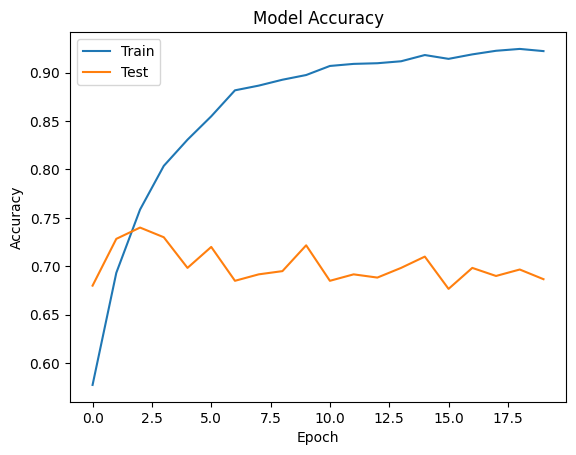

In [ ]:
# Create and save plots for accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("/content/Accuracy.jpeg")
plt.show()


1/1 [==============================] - 2s 2s/step


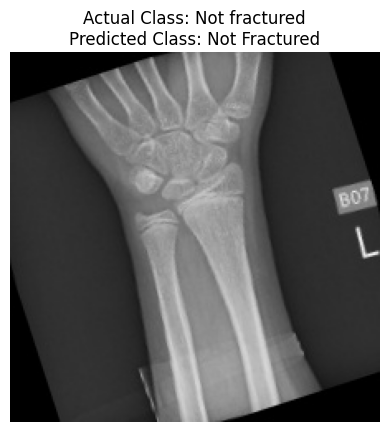

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Paths and configurations
model_path = './ResNet50_fracture_model.h5'  # Update with the path to your saved model
data_dir = './BoneData/Data'

# Load the saved model
model = load_model(model_path)

# Select a random image
random_category = random.choice(['fractured', 'not fractured'])
random_image_path = os.path.join(data_dir, 'val', random_category, random.choice(os.listdir(os.path.join(data_dir, 'val', random_category))))

# Load and preprocess the image
image = load_img(random_image_path, target_size=(224, 224))
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array /= 255.0  # Normalize the image data

# Make predictions
prediction = model.predict(image_array)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.title(f"Actual Class: {random_category.capitalize()}\nPredicted Class: {'Fractured' if prediction[0][0] > 0.4 else 'Not Fractured'}")
plt.show()


In [ ]:
pred_probabilities = resnet_with_residual.predict(test_image_gen)
predictions = pred_probabilities > 0.5
print(classification_report(test_image_gen.classes,predictions))

print(confusion_matrix(test_image_gen.classes,predictions))

2/2 [==============================] - 11s 4s/step
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       360
           1       0.60      0.72      0.65       240

    accuracy                           0.70       600
   macro avg       0.69      0.70      0.69       600
weighted avg       0.71      0.70      0.70       600

[[246 114]
 [ 68 172]]
